In [27]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
# from pprint import pprint
# from lxml import html
# from lxml.html import fromstring
# import urllib.request
from urllib.request import urlopen
# import random
import re
# import scrapy
import matplotlib.pyplot as plt
import datetime
import numpy as np
today = datetime.datetime.now().strftime("%Y-%m-%d")

SCRAPPING

In [21]:
url = "https://tarifaluzhora.es"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
soup.find_all('div', class_='col-display-4')

# now we can find the div with id "hour_prices" and get all the span elements inside
hour_prices_div = soup.find("div", {"id": "hour_prices"})
hour_price_spans = hour_prices_div.find_all("span")

# create a dictionary to store the hours and prices
hours_prices_dict = {}

# loop through the spans and extract the hour and price information
for i in range(0, len(hour_price_spans), 2):
    hour_span = hour_price_spans[i]
    price_span = hour_price_spans[i+1]
    
    # extract the hour and price values and add them to the dictionary
    hour = hour_span.text.strip().replace("h - ", "").replace("h:", "")
    price = price_span.text.strip().replace(" €/kWh", "")
    hours_prices_dict[hour] = price

In [22]:
df_scr = pd.DataFrame.from_dict(hours_prices_dict, orient='index', columns=['price'])
df_scr.index = pd.to_datetime(df_scr.index, format='%H%M%S').floor('H').strftime('%H:%M')
df_scr = df_scr.reset_index().rename(columns={'index': 'hour', 'price': 'price'})
df_scr['price'] = df_scr['price'].astype(float)
df_scr.set_index('hour', inplace=True)
df_scr

,price
hour,
00:00,0.15466
01:00,0.14695
02:00,0.14420
03:00,0.14321
04:00,0.14107
05:00,0.14228
06:00,0.14097
07:00,0.14167
08:00,0.13490


API

In [23]:
url_api = "https://api.open-meteo.com/v1/forecast?latitude=41.39&longitude=2.16&hourly=temperature_2m&forecast_days=14&timezone=auto"
req = requests.get(url_api)
x = req.json()
time1=x['hourly']["time"]
temp=x['hourly']["temperature_2m"]
df_api = pd.DataFrame({'time': x['hourly']['time'], 'temperature_2m': x['hourly']['temperature_2m']})
# Crear una nueva columna 'time_h' con los últimos 5 dígitos de la columna 'time'
df_api['time_h'] = df_api['time'].str[-5:]
# Convertir la columna 'time' al formato de tiempo sin los últimos 6 dígitos
df_api['time'] = pd.to_datetime(df_api['time'].str[:-6], format='%Y-%m-%dT%H:%M')
# Establecer la columna 'time' como el índice del DataFrame
df_api.set_index('time', inplace=True)
# Renombrar la columna 'temperature_2m' como 'temperature'
df_api.rename(columns={'temperature_2m': 'temperature'}, inplace=True)
df_api=df_api.loc[today]
df_api.set_index('time_h', inplace=True)
df_api

,temperature
time_h,
00:00,16.9
01:00,17.2
02:00,17.6
03:00,17.8
04:00,17.6
05:00,17.1
06:00,17.3
07:00,17.4
08:00,18.1


In [24]:
merged_df = df_scr.join(df_api)

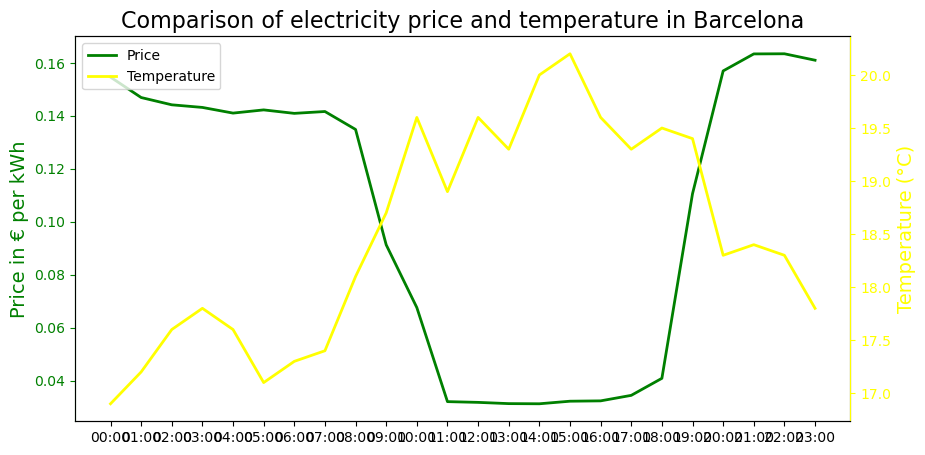

In [25]:
# Generar los datos
x = merged_df.index
y1 = merged_df['price']
y2 = merged_df['temperature']

# Crear la figura y los ejes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Agregar un segundo eje y
ax2 = ax1.twinx()

# Graficar las líneas
line1, = ax1.plot(x, y1, color='green', linewidth=2, label='Price')
line2, = ax2.plot(x, y2, color='yellow', linewidth=2, label='Temperature')

# Configurar el fondo
ax1.set_facecolor('white')
ax2.set_facecolor('white')

# Configurar los colores de los ejes y de las etiquetas
ax1.tick_params(axis='y', colors='green')
ax2.tick_params(axis='y', colors='yellow')
ax1.spines['left'].set_color('green')
ax2.spines['right'].set_color('yellow')
ax1.set_ylabel('Price in € per kWh', color='green', fontsize=14)
ax2.set_ylabel('Temperature (°C)', color='yellow', fontsize=14)

# Agregar un título y leyenda
plt.title('Comparison of electricity price and temperature in Barcelona', fontsize=16)
plt.legend(handles=[line1, line2], loc='upper left')

# Mostrar la gráfica
plt.show()